Notebook for creating the arrays indicating the coast limit and the land limit. 

> This was used for developing the script `landmask.py`, where everything is warpped around functions and it has a brief documentation.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
%matplotlib notebook

In [2]:
def make_grid(fielddata, indices):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    indices is a dictionary such as:
    indices = {'lat': slice(1, 900), 'lon': slice(1284, 2460)}.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables['uo'][0, 0, indices['lat'], indices['lon']]
    landmask = np.ma.masked_invalid(landmask)
    lat = datafile.variables['latitude'][:].data
    lon = datafile.variables['longitude'][:].data

    return landmask, lat, lon

In [3]:
file_path = "../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc"
indices = {'lat': range(1, 900), 'lon': range(1284, 2460)}

In [4]:
def make_landmask(fielddata, indices):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    indices is a dictionary such as:
    indices = {'lat': slice(1, 900), 'lon': slice(1284, 2460)}.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables['uo'][0, 0, indices['lat'], indices['lon']]
    landmask = np.ma.masked_invalid(landmask)
    landmask = landmask.mask.astype('int')

    return landmask

> Import an array with the landmask. `1 = land` and `0 = ocean`

In [5]:
def get_coastal_cells(landmask):
    # Going through ocean cells to see which are next to land
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')

    return coastal

In [6]:
landmask = np.load('../landmask.npy')

<IPython.core.display.Javascript object>


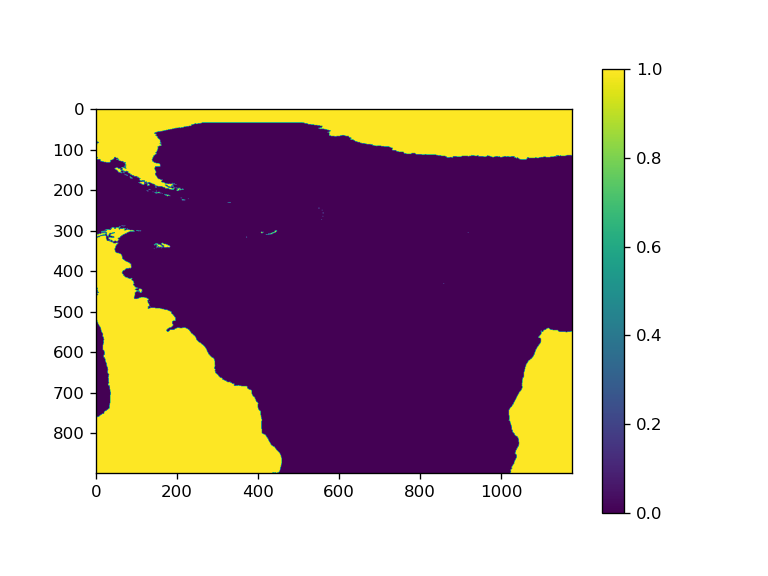

In [9]:
plt.figure()
plt.imshow(landmask)
plt.colorbar()

## Edge detection

In [10]:
mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
mask_lap -= 4*landmask

coastal = ma.masked_array(landmask, mask_lap>0)  # ocean cell next to land.
shore = ma.masked_array(landmask, mask_lap<0)  # land cell next to ocean.
coastal = coastal.mask.astype('int')
shore = shore.mask.astype('int')

<IPython.core.display.Javascript object>


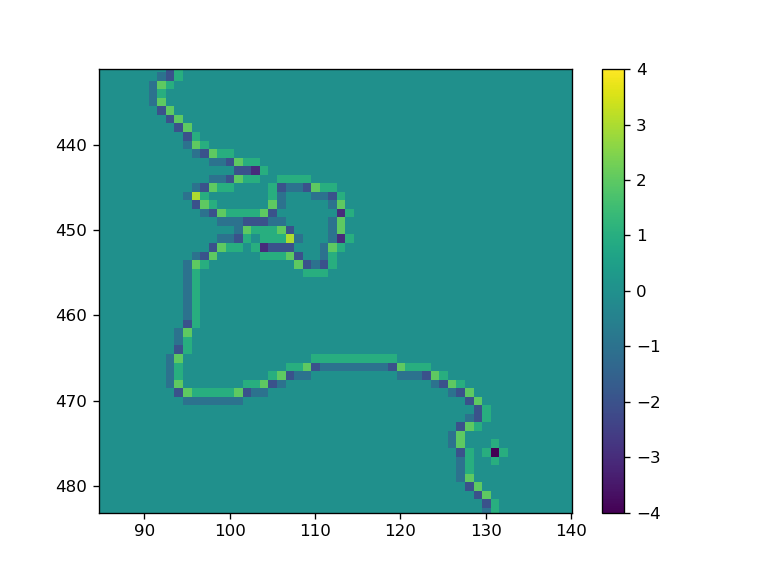

In [11]:
plt.figure()
plt.imshow(mask_lap)
plt.colorbar()

<IPython.core.display.Javascript object>


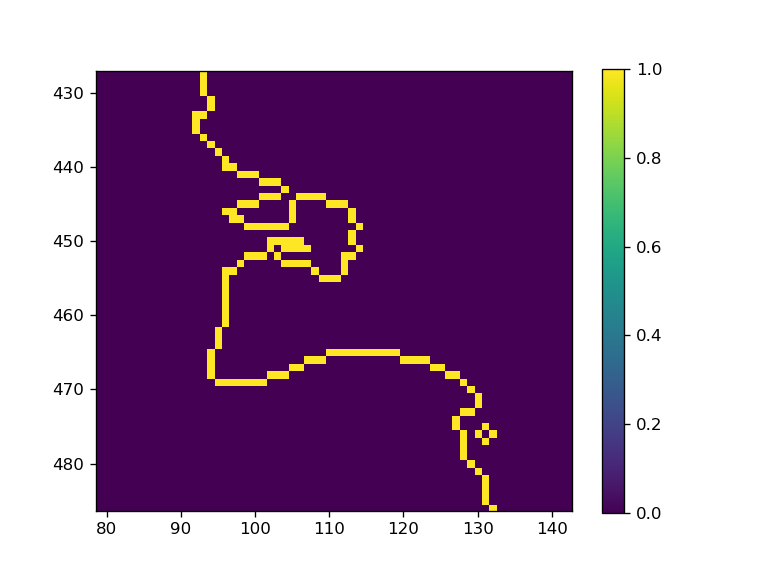

In [12]:
plt.figure()
plt.imshow(coastal)
plt.colorbar()

<IPython.core.display.Javascript object>


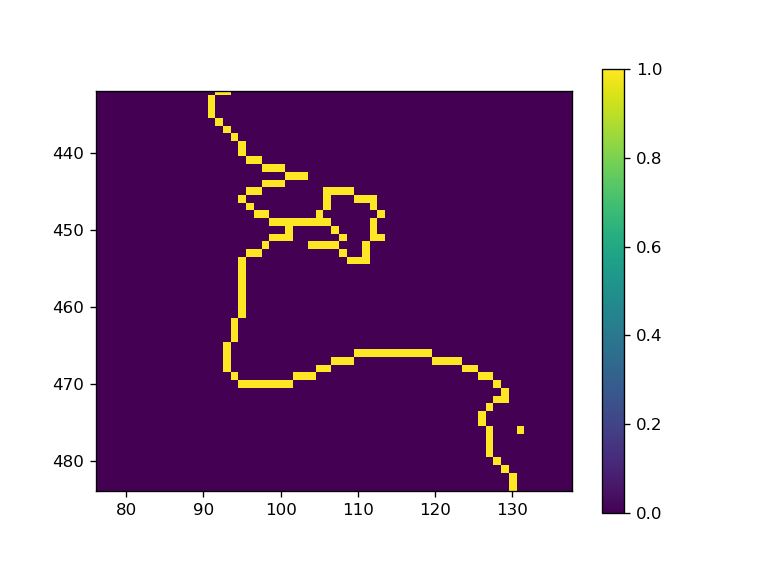

In [13]:
plt.figure()
plt.imshow(shore)
plt.colorbar()

<IPython.core.display.Javascript object>


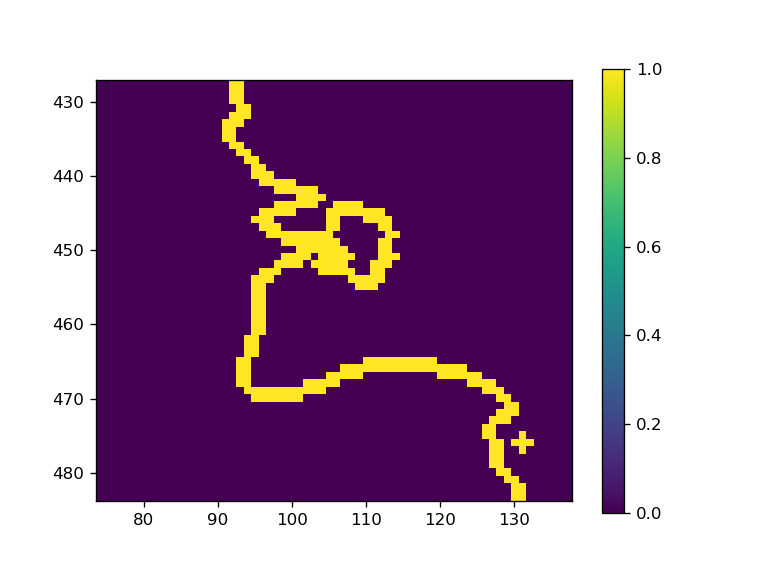

In [14]:
plt.figure()
plt.imshow(shore + coastal)
plt.colorbar()

> obs: the arrays don't ovelap!

Thees is a spellling mistaque on porpoise 

# Asigning coastal velocities

In [15]:
Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)

v_x = np.ma.masked_where(coastal==0, -Lx)
v_y = np.ma.masked_where(coastal==0, -Ly)

magnitude = np.sqrt(v_y**2 + v_x**2)
# the coastal cells between land create a problem. Magnitude there is zero
# I force it to be one to avoid problems when normalizing.
ny, nx = np.where(magnitude==0)
magnitude[ny,nx] = 1

v_x = v_x/magnitude
v_y = v_y/magnitude
v_x.set_fill_value(value=0) # setting fill value to zero.
v_y.set_fill_value(value=0)
# store v_x.data and v_y.data

/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


> The plots are upside-down because I use imshow

<IPython.core.display.Javascript object>


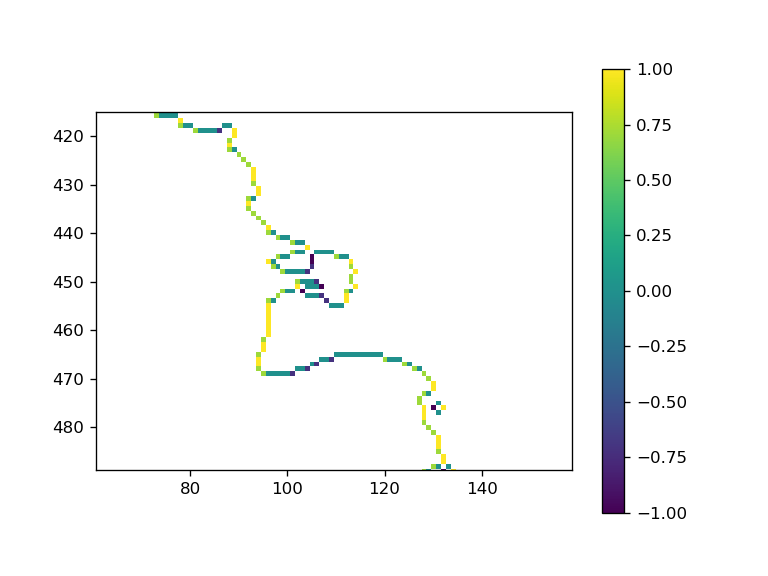

In [16]:
plt.figure()
plt.imshow(v_x)
plt.colorbar()

<IPython.core.display.Javascript object>


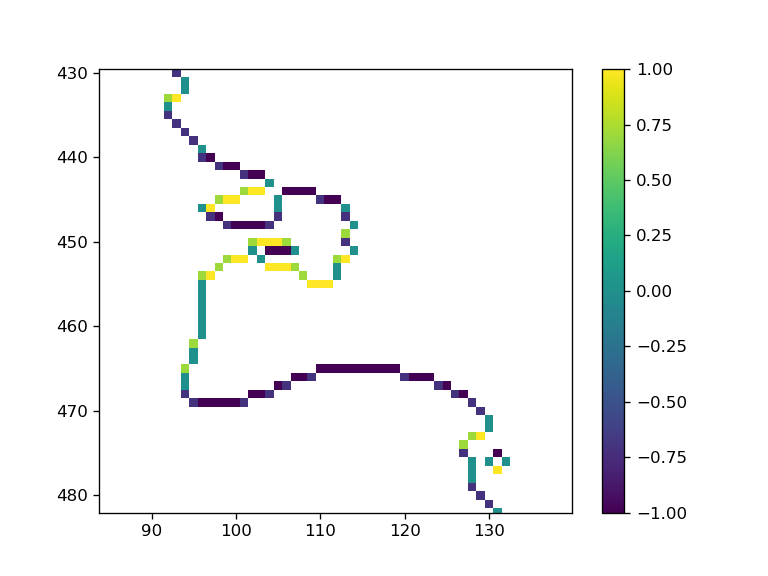

In [17]:
plt.figure()
plt.imshow(v_y)
plt.colorbar()

<IPython.core.display.Javascript object>


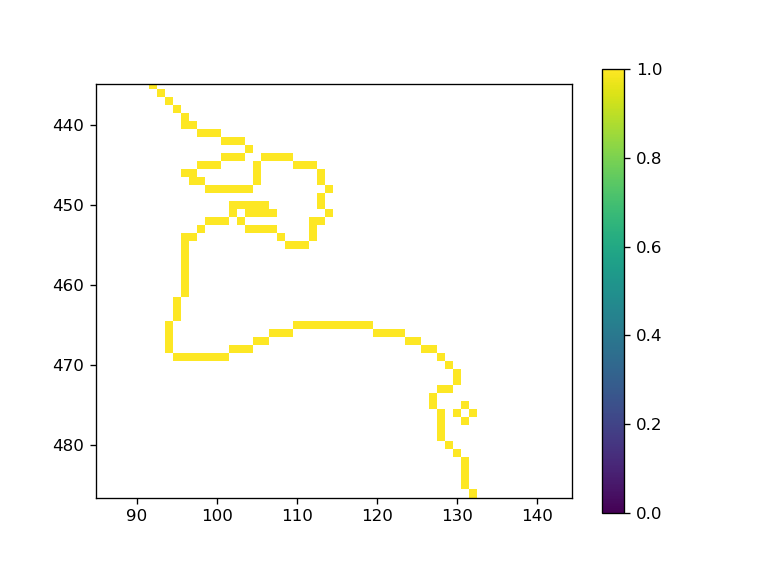

/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [18]:
plt.figure()
plt.imshow(np.sqrt(v_y**2 + v_x**2))
plt.colorbar()

# distance to shore

In [19]:
def get_coastal_cells(landmask):
    # Going through ocean cells to see which are next to land
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')

    return coastal

In [20]:
c1 = get_coastal_cells(landmask)
c2 = get_coastal_cells(landmask + c1)
c3 = get_coastal_cells(landmask + c1 + c2)
c4 = get_coastal_cells(landmask + c1 + c2 + c3)

In [21]:
def distance(landmask, iterations=20, dx=1):
    ci = get_coastal_cells(landmask)
    landmask_i = landmask + ci
    dist = ci
    
    for i in range(iterations):
        ci = get_coastal_cells(landmask_i)
        landmask_i += ci
        dist += ci*(i+1)
    return dist*dx

In [22]:
c100 = distance(landmask)

<IPython.core.display.Javascript object>


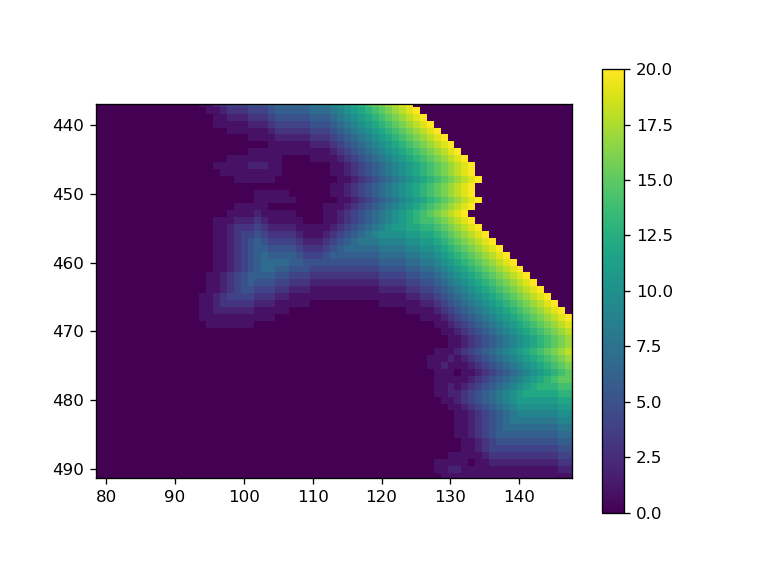

In [23]:
plt.figure()
plt.imshow(c100)
plt.colorbar()